<a href="https://colab.research.google.com/github/unnatikdm/HealthML/blob/main/HealthML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0:	learn: 0.6561366	test: 0.6591607	test1: 0.6569435	best: 0.6569435 (0)	total: 2.7ms	remaining: 807ms
100:	learn: 0.1529679	test: 0.1752803	test1: 0.1579588	best: 0.1579588 (100)	total: 233ms	remaining: 459ms
200:	learn: 0.1065508	test: 0.1244575	test1: 0.1105626	best: 0.1105626 (200)	total: 481ms	remaining: 237ms
299:	learn: 0.0828138	test: 0.0977582	test1: 0.0861112	best: 0.0861112 (299)	total: 801ms	remaining: 0us

bestTest = 0.08611120903
bestIteration = 299

Training Accuracy: 0.9876
Validation Accuracy: 0.9744
Test Accuracy: 0.9900


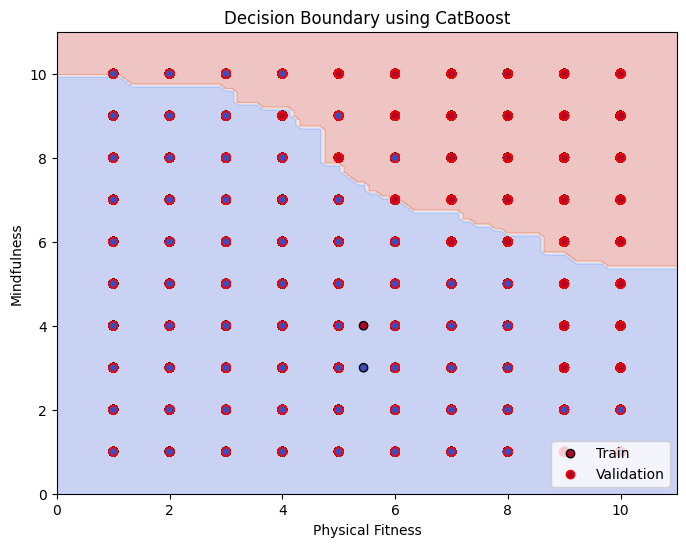

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

df = pd.read_csv("/content/innovize_final_ml.csv")

cat_features = ['diet_pref', 'career', 'gender', 'act_level']

features = ['phy_fitness', 'mindfulness', 'diet_pref', 'career', 'gender',
            'act_level', 'sleep_hrs', 'daily_avg_steps', 'daily_avg_calories']
X = df[features]
y = df['is_healthy']
X = X.copy()

for col in cat_features:
    if X[col].dtype == "object":
        X[col] = X[col].astype(str).fillna("Unknown")
    else:
        X[col] = X[col].fillna("Unknown").astype(str)

num_cols = ['phy_fitness', 'mindfulness', 'sleep_hrs', 'daily_avg_steps', 'daily_avg_calories']
imputer = SimpleImputer(strategy="mean")
X[num_cols] = imputer.fit_transform(X[num_cols])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

cat_model = CatBoostClassifier(
    iterations=300, depth=2, learning_rate=0.05,
    l2_leaf_reg=25, random_strength=5,
    feature_border_type='Uniform',
    loss_function='Logloss', random_seed=42
)

cat_model.fit(X_train, y_train, cat_features=cat_features, verbose=100,
              eval_set=[(X_val, y_val), (X_test, y_test)], early_stopping_rounds=30)

y_pred_val = cat_model.predict(X_val)
y_pred_test = cat_model.predict(X_test)
train_preds = cat_model.predict(X_train)

train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred_val)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

def plot_catboost_decision_boundary(model, X_train, y_train, X_val, y_val, cat_features):
    x_min, x_max = X_train['phy_fitness'].min() - 1, X_train['phy_fitness'].max() + 1
    y_min, y_max = X_train['mindfulness'].min() - 1, X_train['mindfulness'].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid_points = pd.DataFrame({'phy_fitness': xx.ravel(), 'mindfulness': yy.ravel()})

    for col in cat_features:
        grid_points[col] = "Unknown"

    grid_points['sleep_hrs'] = X_train['sleep_hrs'].mean()
    grid_points['daily_avg_steps'] = X_train['daily_avg_steps'].mean()
    grid_points['daily_avg_calories'] = X_train['daily_avg_calories'].mean()

    for col in cat_features:
        grid_points[col] = grid_points[col].astype(str)

    grid_points = grid_points[X_train.columns]

    preds = model.predict(grid_points)
    preds = preds.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap="coolwarm")

    plt.scatter(X_train['phy_fitness'], X_train['mindfulness'], c=y_train, edgecolors="k", cmap="coolwarm", label="Train")
    plt.scatter(X_val['phy_fitness'], X_val['mindfulness'], c=y_val, edgecolors="red", cmap="coolwarm", marker='o', label="Validation")


    plt.xlabel("Physical Fitness")
    plt.ylabel("Mindfulness")
    plt.title("Decision Boundary using CatBoost")
    plt.legend()
    plt.show()

plot_catboost_decision_boundary(cat_model, X_train, y_train, X_val, y_val, cat_features)
